In [2]:
!pip install tonic --quiet
!pip install snntorch --quiet

In [40]:
pip install grad-cam -q

Note: you may need to restart the kernel to use updated packages.


In [12]:
# imports
import tonic
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import tonic.transforms as transforms

import torch
import torchvision

import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
import torch.nn as nn
import time
from IPython.display import HTML


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device('cpu')

In [13]:
dataset = tonic.datasets.DVSGesture(save_to='./data', train=True)
events, label = dataset[0]

# Dataset size
print("Dataset contains ", len(dataset), " samples.")

# Number of events in the first sample
print("There are ", len(events), " events in the first sample.")

# (data-pos, y-pos, polarity, timestamp)
print("A single event: ", events[0])

Dataset contains  1077  samples.
There are  213025  events in the first sample.
A single event:  (49, 82, False, 28)


Shape of frames object:  torch.Size([25, 2, 128, 128])
1077
264


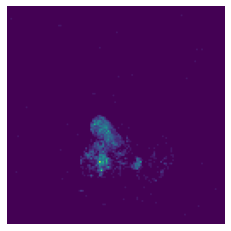

In [44]:
#Frame dataset
size = tonic.datasets.DVSGesture.sensor_size

# Denoise transform removes outlier events with inactive surrounding pixels for 10ms
denoise_transform = transforms.Denoise(filter_time=10000)

# ToFrame transform bins events into 25 clusters of frames
frame_transform = transforms.ToFrame(sensor_size=size, n_time_bins=25)

# Chain the transforms
all_transform = transforms.Compose([denoise_transform, frame_transform, torch.from_numpy, torchvision.transforms.RandomRotation([-10,10])])

# View the transformed data
tf_frames = all_transform(events)
print("Shape of frames object: ", tf_frames.shape)
plt.axis('off')
plt.imshow(tf_frames[0][0])

train_set = tonic.datasets.DVSGesture(save_to='./data', transform=all_transform, train=True)
test_set = tonic.datasets.DVSGesture(save_to='./data', transform=all_transform, train=False)
print(len(train_set))
print(len(test_set))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


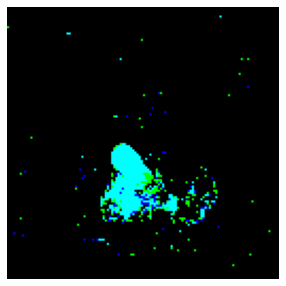

In [6]:
ani = tonic.utils.plot_animation(tf_frames)

In [14]:
HTML(ani.to_jshtml())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [15]:
#Frame
cached_trainset = tonic.DiskCachedDataset(train_set, cache_path='./cache/dvsgesture/train')
cached_testset = tonic.DiskCachedDataset(test_set, cache_path='./cache/dvsgesture/test')

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(cached_trainset, batch_size=128, shuffle=True, drop_last=True, collate_fn=tonic.collation.PadTensors(batch_first=False))
test_loader = torch.utils.data.DataLoader(cached_testset, batch_size=64, shuffle=True, drop_last=True, collate_fn=tonic.collation.PadTensors(batch_first=False))

# Visualize shape of sample in dataloader (similar to frames object above, but 2nd element is batch size)
for sample in iter(train_loader):
  print("Shape of frame sample object: ", sample[0].shape)
  break

Shape of frame sample object:  torch.Size([25, 128, 2, 128, 128])


In [19]:
# Define Network
class SCLU(nn.Module):
    def __init__(self):
        super().__init__()
        beta = 0.8

        # Initialize layers
        self.sclu1 = snn.SConv2dLSTM(2, 8, 5, max_pool=2, threshold=0.1)
        self.sclu2 = snn.SConv2dLSTM(8, 16, 5, max_pool=2, threshold=0.1)
        self.fc = nn.Linear(8*8*16, 11)
        self.lif = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        syn1, mem1 = self.sclu1.init_sconv2dlstm()
        syn2, mem2 = self.sclu2.init_sconv2dlstm()
        mem3 = self.lif.init_leaky()

        # Record the final layer
        spk3_rec = []
        mem3_rec = []

        for step in range(x.size(0)):
            spk1, syn1, mem1 = self.sclu1(x[step], syn1, mem1)
            spk2, syn2, mem2 = self.sclu2(spk1, syn2, mem2)
            cur2 = self.fc(spk2.flatten(1))
            spk3, mem3 = self.lif(cur2, mem3)

            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)


# Load the network onto CUDA if available
net = SCLU().to(device)

# some hyperparameters
optimizer = torch.optim.Adam(net.parameters(), lr=0.002, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

In [28]:
num_epochs = 13
num_iters = 20

loss_hist = []
acc_hist = []
start=time.time()

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(train_loader)):
        # Downsampling image from (128 data 128) to (32 data 32)
        data = nn.functional.interpolate(data, size=(2, 32, 32))
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec, _ = net(data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")

        # training loop breaks after 20 iterations
        if i == num_iters:
          break
end=time.time()
print(f'Total training time{end-start} seconds.')

Epoch 0, Iteration 0 
Train Loss: 0.48
Accuracy: 73.44%

Epoch 0, Iteration 1 
Train Loss: 0.51
Accuracy: 59.38%

Epoch 0, Iteration 2 
Train Loss: 0.50
Accuracy: 70.31%

Epoch 0, Iteration 3 
Train Loss: 0.49
Accuracy: 70.31%

Epoch 0, Iteration 4 
Train Loss: 0.53
Accuracy: 65.62%

Epoch 0, Iteration 5 
Train Loss: 0.52
Accuracy: 57.03%

Epoch 0, Iteration 6 
Train Loss: 0.51
Accuracy: 59.38%

Epoch 0, Iteration 7 
Train Loss: 0.50
Accuracy: 72.66%

Epoch 1, Iteration 0 
Train Loss: 0.48
Accuracy: 67.19%

Epoch 1, Iteration 1 
Train Loss: 0.49
Accuracy: 75.00%

Epoch 1, Iteration 2 
Train Loss: 0.49
Accuracy: 69.53%

Epoch 1, Iteration 3 
Train Loss: 0.45
Accuracy: 70.31%

Epoch 1, Iteration 4 
Train Loss: 0.44
Accuracy: 67.19%

Epoch 1, Iteration 5 
Train Loss: 0.49
Accuracy: 69.53%

Epoch 1, Iteration 6 
Train Loss: 0.47
Accuracy: 64.06%

Epoch 1, Iteration 7 
Train Loss: 0.53
Accuracy: 64.06%

Epoch 2, Iteration 0 
Train Loss: 0.47
Accuracy: 71.88%

Epoch 2, Iteration 1 
Train Los

In [29]:
torch.save(net.state_dict(), 'slstm_beta=.8_DVSGesture.pth')

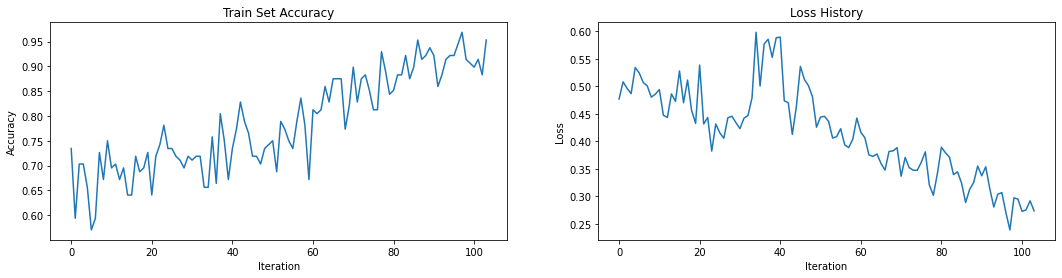

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(18,4))

# Plot Train Accuracy
axes[0].plot(acc_hist)
axes[0].set_title("Training SLSTM on DVS Gesture")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Accuracy")



# Plot Training Loss
axes[1].plot(loss_hist)
axes[1].set_title("Loss History")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Loss")

plt.show()

In [31]:
# Evaluate Test Set Accuracy
correct = 0
total = 0

y_test = []
predictions = []

for i, (data, targets) in enumerate(iter(test_loader)):
  # Downsampling image from (128 data 128) to (32 data 32)
  data = nn.functional.interpolate(data, size=(2, 32, 32))
  data = data.to(device)
  targets = targets.to(device)
  spk_rec, _ = net(data)
  correct += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
  total += spk_rec.size(1)
  _, idx = spk_rec.sum(dim=0).max(1)
  predictions.append(idx)
  y_test.append(targets)

print("Test Set Accuracy: ", (correct/total) * 100, "%")

Test Set Accuracy:  85.15625 %


In [32]:
pred_list=[]
for prediction in predictions:
    pred_list.append(prediction.tolist())

true_list=[]
for test in y_test:
    true_list.append(test.tolist())

In [33]:
mapping = {
    0: "Hand Clapping",
    1: "Right Hand Wave",
    2: "Left Hand Wave",
    3: "Right Arm CW",
    4: "Right Arm CCW",
    5: "Left Arm CW",
    6: "Left Arm CCW",
    7: "Arm Roll",
    8: "Air Drums",
    9: "Air Guitar",
    10: "Other",
}
gestures=list(mapping.values())

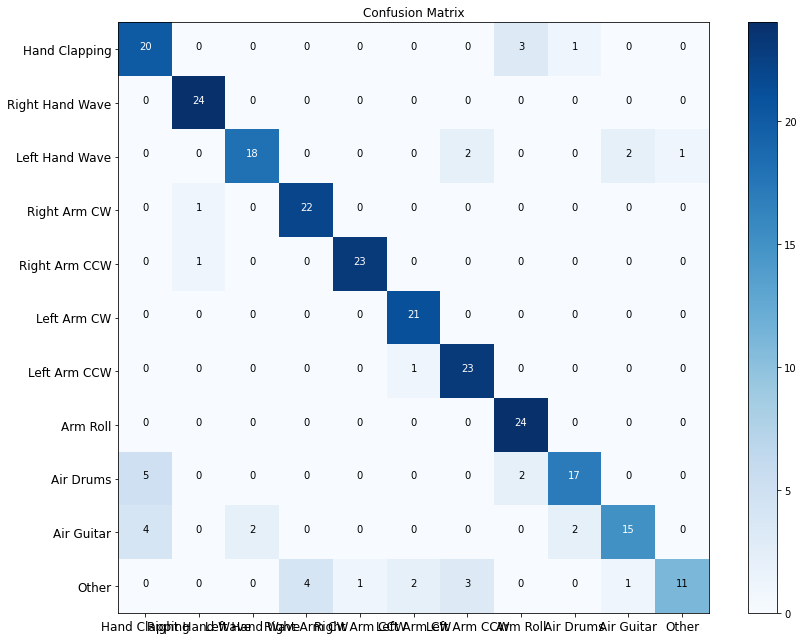

In [34]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

pred_array = np.array([label for sublist in pred_list for label in sublist])
true_array = np.array([label for sublist in true_list for label in sublist])

cm = confusion_matrix(true_array, pred_array)
plt.figure(figsize=(12, 9))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = gestures
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, fontsize=12)
plt.yticks(tick_marks, classes, fontsize=12)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [35]:
from sklearn.metrics import f1_score

f1 = f1_score(true_array, pred_array, average='macro')
print(f"F1 Score:, {round(f1, 2)}")

F1 Score:, 0.84
